In [1]:
from metodos.SSLTree.utils.Experiments import cross_val, names

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata

# Comparativa entre SSLTree, DT y SelfTraining

In [2]:
names2 = ["iris", "zoo"]
all_medians = {}

all_mean_rankings = np.empty((3, 4))

for i, p in enumerate(["10", "20", "30", "40"]):
    medians_ssl = []
    medians_dt = []
    medians_st = []
    for name in names2:
        m_ssl, m_dt, m_st = cross_val(name, p)
        # break
        medians_ssl.append(m_ssl)
        medians_dt.append(m_dt)
        medians_st.append(m_st)
    # break
    print(medians_ssl)
    print(medians_dt)
    print(medians_st)

    all_medians[p] = np.stack((medians_ssl, medians_dt, medians_st))

    rankings = rankdata(-all_medians[p], method="average", axis=0)
    print(rankings)

    all_mean_rankings[:, i] = np.mean(rankings, axis=1)

final_rankings = rankdata(all_mean_rankings, method="average", axis=0)
print(all_mean_rankings)

PERCENTAGE: 10 - DATASET: iris
Mejor w: 0.49 con accuracy: 0.9066666666666666
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: zoo
Mejor w: 0.42 con accuracy: 0.7072222222222223
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
[0.9333333333333333, 0.75]
[0.9333333333333333, 0.788888888888889]
[0.9333333333333333, 0.8541666666666667]
[[2. 3.]
 [2. 2.]
 [2. 1.]]
PERCENTAGE: 20 - DATASET: iris
Mejor w: 0.8200000000000001 con accuracy: 0.9333333333333333
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 20 - DATASET: zoo
Mejor w: 0.38 con accuracy: 0.8086111111111112
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Do

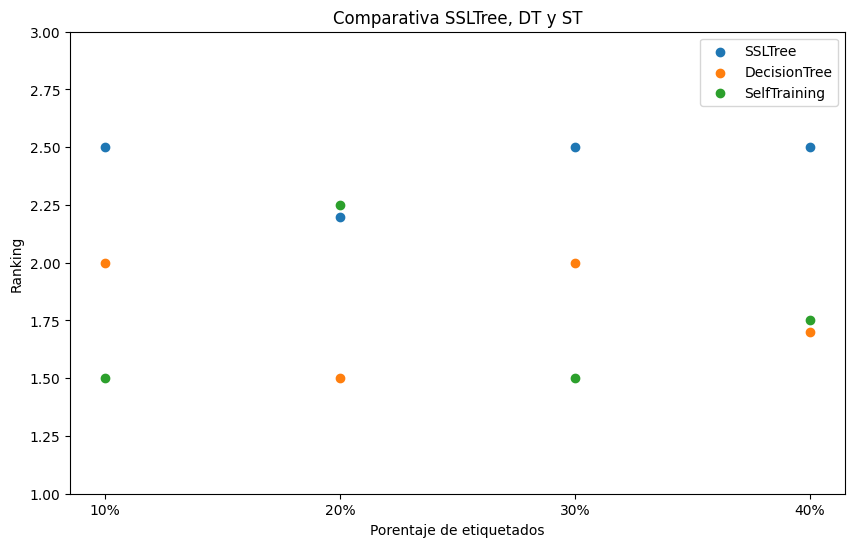

In [3]:
plt.figure(figsize=(10, 6))

for i, percentage in enumerate(["10%", "20%", "30%", "40%"]):
    top = all_mean_rankings[:, i].copy()
    uniques, _ = np.unique(top, return_counts=True)

    displacement = 0.05 * np.linspace(-1, 1, len(uniques), endpoint=False)
    dup = 0
    for j, value in enumerate(top):
        if np.count_nonzero(top == value) > 1:
            all_mean_rankings[j][i] += displacement[dup] if dup < len(displacement) else 0
            dup += 1

classifiers = ["SSLTree", "DecisionTree", "SelfTraining"]
for j, classifier in enumerate(classifiers):
    plt.scatter(["10%", "20%", "30%", "40%"], all_mean_rankings[j], label=classifier)

plt.ylim(1, 3)
plt.xlabel("Porentaje de etiquetados")
plt.ylabel("Ranking")
plt.title("Comparativa SSLTree, DT y ST")

plt.legend()
plt.show()


Ranks promedio: 0    7.500000
1    7.233333
2    6.066667
3    5.066667
4    3.000000
5    3.500000
6    2.133333
7    1.500000
dtype: float64


C:\Users\Acha\Documents\TFM-VIU\venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


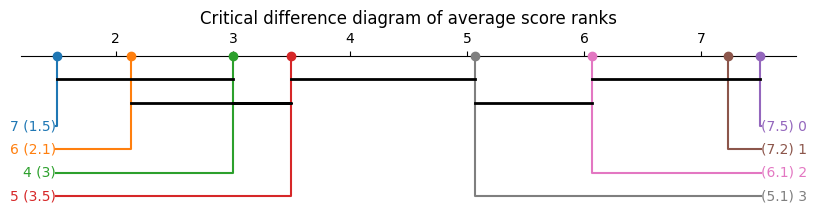

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp

np.random.default_rng(1)
dict_data = {
    'model1': np.random.normal(loc=0.2, scale=0.1, size=30),
    'model2': np.random.normal(loc=0.2, scale=0.1, size=30),
    'model3': np.random.normal(loc=0.4, scale=0.1, size=30),
    'model4': np.random.normal(loc=0.5, scale=0.1, size=30),
    'model5': np.random.normal(loc=0.7, scale=0.1, size=30),
    'model6': np.random.normal(loc=0.7, scale=0.1, size=30),
    'model7': np.random.normal(loc=0.8, scale=0.1, size=30),
    'model8': np.random.normal(loc=0.9, scale=0.1, size=30),
}

data_list = [dict_data[key] for key in dict_data]

results = np.array(data_list).T

nemenyi_result = sp.posthoc_nemenyi_friedman(results)

ranks = np.mean(pd.DataFrame(-results).rank(axis=1, method='average'), axis=0)
print("Ranks promedio:", ranks)

plt.figure(figsize=(10, 2), dpi=100)

plt.title('Critical difference diagram of average score ranks')

sp.critical_difference_diagram(ranks, nemenyi_result)
plt.show()